In [1]:
from captcha.image import ImageCaptcha
from matplotlib import pyplot as plt
import glob
import numpy as np
import random
import os
import string
from PIL import Image 
%matplotlib inline


In [6]:
#image = ImageCaptcha(fonts=['./font/AntykwaBold.ttf', './font/Candice.ttf', './font/VeraMono.ttf', './font/verdana.ttf'])


In [37]:
# %%timeit
# X = []
# for i in range(1000):
#     text = ''.join(random.sample(char_map, 4))
#     img = np.array(image.generate_image(text).resize((100, 40)))
#     img_gray = np.mean(img, -1)
#     if not isinstance(X, np.ndarray):
#         X = img_gray[..., np.newaxis]
#     else:
#         X = np.concatenate((X, img_gray[..., np.newaxis]), axis=-1)
#     #灰度值求解
#     #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
#     if i % 100 == 0:
#         print("generating captcha " , i)

num_char = 4
num_images = 10000
width_images = 100
height_images = 40
num_charmap = 36
num_channel = 1
X = np.empty((num_images, height_images, width_images))
y = np.empty((num_images, num_charmap*num_char))
char_map = string.ascii_uppercase + string.digits

image_generator = ImageCaptcha(fonts=['./font/AntykwaBold.ttf'])
for i in range(num_images):
    text = ''.join(random.sample(char_map, num_char))
    img = np.array(image_generator.generate_image(text).resize((width_images, height_images)))
    img_gray = np.mean(img, -1)
    img_scale = np.multiply(img_gray, 1/255.0)
    X[i, :, :] = img_scale
    y_index = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
    y[i, y_index] = 1

    #灰度值求解
    #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
    if i % (num_images/10) == 0:
        print("generating captcha " , i)

generating captcha  0
generating captcha  1000
generating captcha  2000
generating captcha  3000
generating captcha  4000
generating captcha  5000
generating captcha  6000
generating captcha  7000
generating captcha  8000
generating captcha  9000


In [40]:
def generator(X, y, batch_size=100):
    index_in_epoch = 0
    while True:
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_images:
            perm = np.arange(num_images)
            np.random.shuffle(perm)
            X = X[perm]
            y = y[perm]
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_images
        end = index_in_epoch
        yield X[start:end], y[start:end]

In [43]:
import tensorflow as tf
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, width_images*height_images])
y_ = tf.placeholder(tf.float32, shape=[None, num_char*num_charmap])

In [63]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1, height_images, width_images, 1]) # -1 use to flatten x, x_image.shape=(1, 28, 28, 1)

#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#Third Convolutional Layer
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool3 = max_pool_2x2(h_conv2)

#First densely Connected Layer
W_fc1 = weight_variable([10 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 144])
b_fc2 = bias_variable([144])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
cross_entropy_2 = tf.reduce_mean(
    tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
                y_conv[:, 36*i:36*i+35], y_[:, 36*i:36*i+35]) for i in range(num_char) ]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_2)
correct_prediction = [tf.equal(tf.argmax(y_conv[:, 36*i:36*i+35],1),
           tf.argmax(y_[:, 36*i:36*i+35],1)) for i in range(num_char)]
accuracy = tf.reduce_mean(tf.reduce_min(tf.cast(correct_prediction, tf.float32), axis=0))
sess.run(tf.global_variables_initializer())
for i in range(20000):
    trainset_ge = generator(X, y, batch_size=64)
    X_train, y_train = next(trainset_ge)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:X_train, y_: y_train, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: X_train, y_: y_train, keep_prob: 0.5})

# print("test accuracy %g"%accuracy.eval(feed_dict={
#     x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0
step 100, training accuracy 0.3125
step 200, training accuracy 0.890625
step 300, training accuracy 0.9375
step 400, training accuracy 0.9375
step 500, training accuracy 0.9375
step 600, training accuracy 0.9375


KeyboardInterrupt: 

array([[33],
       [25],
       [12],
       [11]])

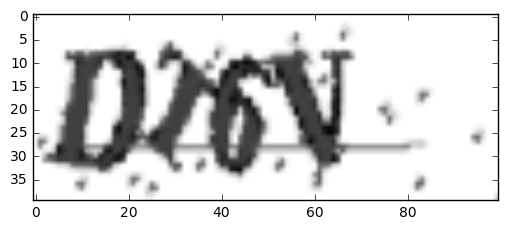

In [121]:
text = ''.join(random.sample(char_map, num_char))
img = np.array(image_generator.generate_image(text).resize((width_images, height_images)))
img_gray = np.mean(img, -1)
plt.imshow(img_gray, cmap='gray')
img_scale = np.multiply(img_gray, 1/255.0)
predict = tf.cast([tf.argmax(y_conv[:, 36*i:36*i+35],1) for i in range(num_char)], dtype=tf.int32)
X_test = img_scale.reshape(1, width_images*height_images)
predict.eval(feed_dict={x: X_test, keep_prob: 1.0})

In [122]:
cross_entropy_2

<tf.Tensor 'Mean_10:0' shape=() dtype=float32>

In [119]:
y_index = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
y_test = np.zeros((1, 144))
y_test[0, y_index] = 1
accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})

0.0

In [107]:
elems = (np.array([1, 2, 3]), np.array([-1, 1, -1]))
alternate = map_fn(lambda x: x[0] * x[1], elems, dtype=tf.int64)
tf.map_fn()

0

In [104]:
_x = X_test[:,51:90]

In [117]:
type(y_train)

numpy.ndarray

In [196]:
np.concatenate((img2, img.reshape((40, 100, 1))), axis =2).shape

(40, 100, 3)

In [205]:
X = np.empty((40, 100, 1))

In [207]:
np.concatenate((img2, X), axis =2).shape

(40, 100, 3)